#  Module 1 : Parts modales

**Description** : Le but de ce module est de mener un premier calcul des parts modales kilométriques i.e. les distances journalières moyennisées par mode et par motif.

**Durée estimée première partie** : 7 jours

**Objectifs spécifiques** :
- [x] Sous-échantillonnage des résidents et visiteurs par canton (basé sur le GPS)
- [x] Rééchantillonnage des jours d’observation pour avoir un calendrier continue par usager
- [ ] Intégrer le détail des transit
- [x] Distinguer de façon aussi systématique que possible les jours sans déplacement des jours
non-détectés et comparaison statistique au jours non-déplacé dans d’autres bases de
données
- [ ] Recodage des modes et motifs selon besoin des cantons
- [x] Calcul liminaire des parts modales kilométriques et par déplacements
- [ ] Ajout des données d’équipement (e.g. type de motorisation principale du ménage)
- [ ] Documenter les hypothèses et limites du calcul liminaire des parts modales (e.g. aspects
saisonniers, échantillonnage, perte de signal, moyennisation des données longitudinales, ...)

**Résultats attendus** : Parts modales kilométriques par mode pour les résidents et visiteurs de chaque canton en vue du calcul des émissions carbone. Il doit être possible de calculer les parts modales en tenant compte des jours non-mobiles.

**Sous-échantillonnage** :
- Vaud : résident·es du canton
- Genève : résident·es du canton

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

from shapely import geometry, ops
from shapely.geometry import MultiLineString, LineString, Point
import os
import concurrent.futures
from shapely.ops import unary_union
from shapely.geometry import JOIN_STYLE, Polygon, MultiPolygon

import pycountry
import xyt

import time

### Charger les données

In [4]:
%%time
# Définir le CRS du projet (EPSG:4326 for WGS84)
target_crs = 'EPSG:4326'
print("CRS du projet: WGS84 \n")

#Charger les étapes
legs = pd.read_pickle('../Data/time_space_filters/legs_filtered.pkl')
del legs['canton_dep']
legs['started_at'] = pd.to_datetime(legs['started_at'])
legs['finished_at'] = pd.to_datetime(legs['finished_at'])
legs.rename(columns={'IDNO':'user_id_fors', 'id':'leg_id'}, inplace = True)
del legs['scattered_tracking']

print("Fichier étape chargé")

#Charger les activités
staypoints = pd.read_pickle('../Data/time_space_filters/staypoints_filtered.pkl').reset_index(drop=True)
staypoints = gpd.GeoDataFrame(staypoints, geometry="geometry", crs=target_crs)

staypoints['started_at'] = pd.to_datetime(staypoints['started_at'])
staypoints['finished_at'] = pd.to_datetime(staypoints['finished_at'])
staypoints.rename(columns={'IDNO':'user_id_fors', 'id':'activity_id'}, inplace = True)
staypoints['lon'] = staypoints.geometry.x
staypoints['lat'] = staypoints.geometry.y
del staypoints['scattered_tracking']

print("Fichier activité chargé")

#Charger les user_statistics
usr_stats = pd.read_pickle('../Data/processed_feuille_de_route/gps_user_statistics.pkl')
print("Fichier statistiques utilisateur·ices chargé")

#Charger les trips
trips = pd.read_csv('../Data/dumps_motiontag/Trips.2023-04-01--2023-08-31.csv')
print("Fichier des déplacements chargé")

#Charger les bases officielles pour le sous-échantillonage géographique https://opendata.swiss/de/dataset/vm-uvek-zones-2017/resource/29b98f2c-42f2-4e72-b8b1-a39500ed0ad0
TAZ = gpd.read_file('../../Vague1/Verkehrszonen_Schweiz_NPVM_2017_shp/Verkehrszonen_Schweiz_NPVM_2017.shp')
TAZ = TAZ[['ID_Agglo', 'N_Agglo', 'N_KT', 'ID_Gem', 'geometry']]
TAZ = TAZ.to_crs(crs=target_crs)
#repare anomalies
TAZ['geometry'] = TAZ['geometry'].buffer(0)
shp_KT = TAZ.dissolve(by='N_KT').reset_index()
print("Fichier Zones de traffic chargé")

# Get world countries GeoDataFrame
def get_world_countries():
    world_countries = gpd.read_file('../Data/other_shp/countries/ne_110m_admin_0_countries.shp')
    world_countries = world_countries[['SOVEREIGNT','geometry']]
    return world_countries
world_countries = get_world_countries()
print("Fichier Map Monde chargé")

# Get perimetre panel GeoDataFrame
perimetre_panel = gpd.read_file('../Data/other_shp/perimetre_panel/perimetre_panel_08.01.24.shp')
perimetre_panel = perimetre_panel.to_crs(crs=target_crs)
perimetre_panel = perimetre_panel[['COMM_ID','COMM_NAME','Typo_panel','geometry']]
perimetre_panel['panel_area'] = 1

def close_holes(poly: Polygon) -> Polygon:
        """
        Close polygon holes by limitation to the exterior ring.
        Args:
            poly: Input shapely Polygon
        Example:
            df.geometry.apply(lambda p: close_holes(p))
        """
        if poly.interiors:
            return Polygon(list(poly.exterior.coords))
        else:
            return poly

perimetre_panel_full = perimetre_panel.dissolve().geometry.apply(lambda p: close_holes(p))
perimetre_panel_full = gpd.GeoDataFrame(geometry=[perimetre_panel_full.iloc[0]], crs=target_crs)
perimetre_panel_full['panel_area'] = 1
print("Fichier Périmètre panel chargé")

CRS du projet: WGS84 

Fichier étape chargé
Fichier activité chargé
Fichier statistiques utilisateur·ices chargé
Fichier des déplacements chargé
Fichier Zones de traffic chargé
Fichier Map Monde chargé
Fichier Périmètre panel chargé
CPU times: user 19.1 s, sys: 8.01 s, total: 27.1 s
Wall time: 31.7 s


#### Ajouter un ID par usager-jour

In [5]:
#Ajouter le user_id_day
legs.insert(1, 'legs_date',legs.started_at.dt.date)
legs['legs_date'] = pd.to_datetime(legs['legs_date'])

legs.insert(
    1,"user_id_day",legs["user_id_fors"]
    + "_" 
    + legs.started_at.dt.year.astype(str)
    + legs.started_at.dt.month.astype(str).str.zfill(2)
    + legs.started_at.dt.day.astype(str).str.zfill(2),
)

### Ajouter le *next activity_id* aux étapes

In [6]:
# Sort 'points' and 'legs' by 'started_at' to ensure data is in chronological order
staypoints.sort_values(by=['user_id_fors','started_at'], inplace=True, ignore_index=True)
legs.sort_values(by=['user_id_fors','started_at'], inplace=True)

In [7]:
legs = pd.merge(legs, staypoints[['activity_id', 'previous_leg_id']],
               left_on='leg_id', right_on='previous_leg_id', how='left')
legs.rename(columns={'activity_id':'leading_stay_id'}, inplace=True)
del legs['previous_leg_id']

###  Ajouter la durée et la longueur des étapes

In [8]:
%%time 
# Add length in meters
legs['length'] = legs.to_crs('EPSG:2056').length
# Add the duration in seconds
legs['duration'] = (legs['finished_at'] - legs['started_at']).dt.total_seconds()

CPU times: user 1min 3s, sys: 24.4 s, total: 1min 28s
Wall time: 1min 44s


### Extraire les aires géographiques et les sous-échantillons (Genève et Vaud)
Nous utilisons les zones de traffic du Modèle Voyageur de l'ARE.

We want to sample :
- all the residents of Canton de Genève
- all the activities that happen in Canton de Genève

To do that we flag all destionation Kantons in the oclumns _leading_stay_id_in_KT_

In [9]:
#staypoints_ = staypoints.copy()
#staypoints = staypoints_.copy()

In [10]:
%%time
# Perform spatial join of staypoints with world_countries
staypoints = gpd.sjoin(staypoints, world_countries, how='left', predicate='within').rename(columns={'SOVEREIGNT':'activity_in_country'})

# Fill NaN values in the 'country_name' column with 'Unknown'
staypoints['activity_in_country'] = staypoints['activity_in_country'].fillna('Unknown')
staypoints.drop(columns=['index_right'], inplace=True)

# Perform spatial join with TAZ
staypoints = gpd.sjoin(staypoints, TAZ[['N_KT', 'geometry']], how='left', predicate='within').rename(columns={'N_KT': 'activity_in_KT'})
staypoints.drop(columns=['index_right'], inplace=True)
# Adjust the saptial join for corner cases
staypoints.loc[~staypoints.activity_in_KT.isna(),'activity_in_country'] = 'Switzerland'
staypoints['activity_in_KT'] = staypoints['activity_in_KT'].fillna('Other')

# Perform spatial join with Panel Lemanique area
# Function to check if a point is within the panel's geometry
staypoints = gpd.sjoin(staypoints, perimetre_panel_full.dissolve(), how='left', predicate='within')
staypoints.loc[staypoints.panel_area.isna(),'panel_area'] = 0
staypoints['panel_area'] = staypoints.panel_area.astype(int)
staypoints.drop(columns=['index_right'], inplace=True)

# Get the home and motorization of the user_
staypoints = pd.merge(staypoints, usr_stats[['KT_home_survey','user_id_fors','car_in_HH_count','main_motor']], on='user_id_fors', how='left')

CPU times: user 5.14 s, sys: 1.48 s, total: 6.61 s
Wall time: 7 s


In [11]:
%%time
legs = pd.merge(legs, staypoints[['activity_id','activity_in_KT','panel_area','KT_home_survey','car_in_HH_count','main_motor']].dropna(subset='activity_id'),
                left_on='leading_stay_id',
                right_on='activity_id',
                how='left')

CPU times: user 834 ms, sys: 220 ms, total: 1.05 s
Wall time: 1.1 s


#### Cartographie pour vérifier les filtres

In [12]:
staypoints.head(2)

,activity_id,started_at,finished_at,type,started_at_timezone,purpose,user_id_fors,geometry,started_date,previous_leg_id,previous_mode,next_leg_id,next_mode,lon,lat,activity_in_country,activity_in_KT,panel_area,KT_home_survey,car_in_HH_count,main_motor
0,2f587959-8604-44c6-bf28-f19e2bf0913b,2023-05-02 13:04:38,2023-05-02 14:46:42,Stay,Europe/Zurich,unknown,CH01,POINT (6.58428 46.54247),2023-05-02,NaN,NaN,aa257257-d427-4a84-81b1-fe3bad92050b,Mode::Car,6.584277,46.542471,Switzerland,VD,1,VD,2.0,essence
1,7dd02868-9907-4315-85e6-810913107a65,2023-05-02 15:56:14,2023-05-02 18:26:22,Stay,Europe/Zurich,unknown,CH01,POINT (6.94385 46.27073),2023-05-02,aa257257-d427-4a84-81b1-fe3bad92050b,Mode::Car,5de690c8-5ee3-46d6-8dce-0733532c6c79,Mode::Car,6.943852,46.270734,Switzerland,VS,1,VD,2.0,essence


In [13]:
%autoreload
xyt.plot_gps(staypoints[staypoints.activity_in_KT == 'VD'].rename(columns={'user_id_fors':'user_id'}).dropna()[:2000], geo_columns='geometry')

In [14]:
import pandas as pd

def get_daily_modal_distances(df):
    
    # Create a copy of the DataFrame to avoid modifying the original
    df = df.copy()
    
    df['length'] = df['length'].astype(float)
    # Group by 'user_id_day', 'previous_mode', and 'previous_leg_id', then sum the distances
    grouped = df.groupby(['user_id_fors', 'user_id_day', 'mode'])['length'].sum().reset_index()

    # Pivot the table to have modes as columns
    pivoted = grouped.pivot_table(
        index=['user_id_fors', 'user_id_day'],
        columns='mode',
        values='length',
        aggfunc='sum'
    ).reset_index()

    # Resample to include missing days and fill NaNs with different values in different columns
    pivoted['date'] = pd.to_datetime(pivoted['user_id_day'].str[-8:])
    # Create a date range covering the entire date range for each ID
    date_ranges = pivoted.groupby('user_id_fors')['date'].agg(['min', 'max']).reset_index()
    date_ranges['legs_date'] = date_ranges.apply(lambda row: pd.date_range(row['min'], row['max'], freq='D'), axis=1)

    # Create a Cartesian product of IDs and date ranges
    cartesian = date_ranges.explode('legs_date').reset_index(drop=True)

    # Complete the original df with a continuous timeline
    pivoted_filled = pd.merge(pivoted, cartesian[['user_id_fors', 'legs_date']], how='outer', left_on=['user_id_fors', 'date'],
                              right_on=['user_id_fors', 'legs_date'])

    # Create 'days_without_track' column and mark as True for added rows, False otherwise
    pivoted_filled['days_without_track'] = pivoted_filled['date'].isnull().astype(int)
    del pivoted_filled['date']

    # Fill missing values in the user_id_day column
    pivoted_filled['user_id_day'] = pivoted_filled.apply(
        lambda row: row['user_id_day'] if not pd.isnull(row['user_id_day'])
        else row['user_id_fors'] + "_" +
             row['legs_date'].strftime('%Y%m%d'),
        axis=1
    )

    # Fill missing values in the modes columns
    # Get the columns that start with 'Mode::'
    modes_columns = [col for col in pivoted_filled.columns if col.startswith('Mode::')]

    # Fill missing values in the 'modes_columns' with 0
    pivoted_filled[modes_columns] = pivoted_filled[modes_columns].fillna(0)

    # Sort the resulting DataFrame
    pivoted_filled.sort_values(by=['user_id_fors', 'legs_date'], inplace=True)

    return pivoted_filled


###  Get the weighted sum distance per user in meter

In [15]:
legs_nogeometry = legs.copy()
del legs_nogeometry['geometry']
legs_nogeometry.to_pickle('../Data/processed_feuille_de_route/legs_nogeometry.pkl')

In [16]:
legs_nogeometry.head()

,leg_id,user_id_day,legs_date,started_at,finished_at,type,started_at_timezone,detected_mode,mode,user_id_fors,low_quality_legs_1,low_quality_legs_2,leading_stay_id,length,duration,activity_id,activity_in_KT,panel_area,KT_home_survey,car_in_HH_count,main_motor
0,aa257257-d427-4a84-81b1-fe3bad92050b,CH01_20230502,2023-05-02,2023-05-02 14:46:42,2023-05-02 15:56:14,Track,Europe/Zurich,Mode::Car,Mode::Car,CH01,0,0,7dd02868-9907-4315-85e6-810913107a65,54830.991458,4172.0,7dd02868-9907-4315-85e6-810913107a65,VS,1.0,VD,2.0,essence
1,5de690c8-5ee3-46d6-8dce-0733532c6c79,CH01_20230502,2023-05-02,2023-05-02 18:26:22,2023-05-02 18:39:12,Track,Europe/Zurich,Mode::Car,Mode::Car,CH01,0,0,NaN,10293.051705,770.0,NaN,NaN,NaN,NaN,NaN,NaN
2,a6fa18d2-a25b-4f9d-ba5e-f91bc758774f,CH01_20230502,2023-05-02,2023-05-02 18:39:17,2023-05-02 18:48:41,Track,Europe/Zurich,Mode::Walk,Mode::Walk,CH01,0,0,59acb1a8-2a61-4cba-b2ea-cb563e7ae7fa,179.019953,564.0,59acb1a8-2a61-4cba-b2ea-cb563e7ae7fa,VD,1.0,VD,2.0,essence
3,4f2b8865-3290-4d4c-826d-7524d2278da9,CH01_20230503,2023-05-03,2023-05-03 04:26:51,2023-05-03 05:13:57,Track,Europe/Zurich,Mode::Car,Mode::Car,CH01,0,0,872eee0c-b72e-4e1f-8a20-f12c5e9ff5a7,55009.776548,2826.0,872eee0c-b72e-4e1f-8a20-f12c5e9ff5a7,VD,1.0,VD,2.0,essence
4,c17d2027-28a0-4124-a7e1-2ed227436310,CH01_20230503,2023-05-03,2023-05-03 09:49:49,2023-05-03 09:50:45,Track,Europe/Zurich,Mode::Walk,Mode::Walk,CH01,0,0,a6ec5bd7-1c05-4845-830d-2a9ac870b9a0,97.611720,56.0,a6ec5bd7-1c05-4845-830d-2a9ac870b9a0,VD,1.0,VD,2.0,essence


In [17]:
#Compute daily modal distances
def calculate_dmd(legs_nogeom, usr_stats, KT, weight, period_of_tracking, visitors, airplane, incl_signal_loss):

    legs_nogeometry = legs_nogeom.copy()
    # Filter Airplane if needed
    if not airplane:
        legs_nogeometry = legs_nogeometry[legs_nogeometry['mode'] != 'Mode::Airplane'].copy()

    # Filter tracks with signal loss
    if not incl_signal_loss:
        legs_nogeometry = legs_nogeometry[legs_nogeometry['low_quality_legs_1'] == 0].copy()
        
        
    # Creating a dictionary mapping user IDs to their corresponding weight values
    # If weight is 'Aucun', map each user ID to the value 1
    if weight == 'Aucun':
        weight_mapping = usr_stats.set_index('user_id_fors').apply(lambda x: 1, axis=1).to_dict()
    else:
        weight_mapping = usr_stats.set_index('user_id_fors')[weight].to_dict()
    
    # Creating a dictionary mapping user IDs to their corresponding period of tracking values
    active_days_mapping = usr_stats.set_index('user_id_fors')[period_of_tracking].to_dict()
    
    # Setting the condition based on the value of KT
    # If KT is not 'Tous', filter data based on the condition KT_home_survey == KT
    # If KT is 'Tous', include all data (no filtering based on KT)
    if KT != 'Tous':
        KT_condition = (legs_nogeometry.KT_home_survey == KT)
    else:
        KT_condition = True

    if visitors == True:
        visit_condition = (legs_nogeometry.activity_in_KT == KT)
        dmd = get_daily_modal_distances(legs_nogeometry.loc[KT_condition | visit_condition])
    else:
        dmd = get_daily_modal_distances(legs_nogeometry.loc[KT_condition])
    
    # Filtering columns that start with 'Mode::' for further calculations
    mode_columns = dmd.filter(like='Mode::')
    
    # Calculating the sum for each 'Mode::' column for each user_id
    sum_mode_per_user = mode_columns.groupby(dmd['user_id_fors']).apply(lambda x: x.sum())
    
    # Weighting the sum of each 'Mode::' column based on user weights and active days
    sum_mode_per_user_w = sum_mode_per_user.mul(sum_mode_per_user.index.map(weight_mapping), axis=0).div(sum_mode_per_user.index.map(active_days_mapping), axis=0).dropna()

    return sum_mode_per_user_w.astype(int)


In [18]:
# Possible values: 'GE', 'VD', 'Tous'
KT = 'Tous'
# Possible values: 'wgt_agg_trim_gps', 'wgt_cant_gps', 'wgt_agg_gps', 'wgt_cant_trim_gps', 'Aucun'
weight = 'wgt_agg_trim_gps' 

# Selecting the period of tracking for user activities
# Possible values: 'active_days_count', 'days_with_track'
period_of_tracking = 'active_days_count'

visitors = True
airplane = False
remove_signal_loss = False
dmd = calculate_dmd(legs_nogeometry, usr_stats, KT, weight, 
              period_of_tracking, visitors, airplane,remove_signal_loss)

dmd

,Mode::Bicycle,Mode::Bikesharing,Mode::Bus,Mode::Car,Mode::Carsharing,Mode::Ebicycle,Mode::Ecar,Mode::KickScooter,Mode::LightRail,Mode::Motorbike,Mode::Other,Mode::RegionalTrain,Mode::Subway,Mode::TaxiUber,Mode::Train,Mode::Tram,Mode::Walk
user_id_fors,,,,,,,,,,,,,,,,,
CH01,0,0,322,122253,0,0,0,0,627,0,0,0,0,0,1632,0,1362
CH10003,532,0,34,3273,0,0,0,0,349,0,0,1416,0,0,0,13,996
CH10039,4622,0,1831,117568,0,0,0,0,0,0,0,0,0,0,0,0,1851
CH10068,0,0,1208,45341,0,0,0,0,202,0,0,0,0,0,0,0,1423
CH1007,2720,0,441,6822,0,0,0,0,676,0,0,0,17,0,26929,0,604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FR9891,1878,0,0,59203,0,0,0,0,0,0,0,0,0,0,0,25,2731
FR996,1245,0,0,50804,0,0,0,0,0,0,0,46619,3452,0,34177,3992,4744
FR9983,2,0,37,5203,0,0,0,0,0,0,0,0,0,0,31,0,75


In [19]:
import pandas as pd

def dmd_aggreg_modes(dmd, level):
    df = dmd.copy()

    if level == "Motiontag":
        return df
    else:
        if level == "MRMT":
            # First level of mode mapping
            mode_mapping = {
                'Voiture conducteur': ['Mode::Car', 'Mode::Carsharing','Mode::Ecar'],
                'Taxi': ['Mode::TaxiUber'],
                '2RM': ['Mode::KickScooter','Mode::Motorbike'],
                'Train': ['Mode::RegionalTrain','Mode::Train'],
                'Bus': ['Mode::Bus'],
                'Tram/Métro': ['Mode::LightRail','Mode::Subway','Mode::Tram'],
                'Bateau': ['Mode::Boat'],
                'Marche': ['Mode::Walk'],
                'Vélo conventionnel': ['Mode::Bicycle', 'Mode::Bikesharing'],
                'Vélo électrique': ['Mode::Ebicycle'],
                'Engins assimilés à des véhicules': ['Mode::Other'],
                'Avion': ['Mode::Airplane']
            }
    
        elif level == "Niveau 1":
            # Second level of mode mapping
            mode_mapping = {
                'Voiture conducteur': ['Mode::Car', 'Mode::Carsharing','Mode::Ecar','Mode::TaxiUber'],
                '2RM': ['Mode::KickScooter', 'Mode::Motorbike'],
                'Train': ['Mode::Train','Mode::RegionalTrain'],
                'Autre TP': ['Mode::Bus','Mode::LightRail','Mode::Subway','Mode::Tram','Mode::Boat'],
                'Marche': ['Mode::Walk'],
                'Vélo': ['Mode::Bicycle', 'Mode::Bikesharing','Mode::Ebicycle'],
                'Autre': ['Mode::Other'],
                'Avion': ['Mode::Airplane']
            }
    
        elif level == "Niveau 2":
            # Third level of mode mapping
            mode_mapping = {
                'TIM': ['Mode::Car', 'Mode::Carsharing','Mode::Ecar', 'Mode::KickScooter','Mode::Motorbike','Mode::TaxiUber'],
                'TP': ['Mode::Boat','Mode::Bus','Mode::LightRail','Mode::RegionalTrain', 'Mode::Subway','Mode::Train', 'Mode::Tram'],
                'MD': ['Mode::Bicycle', 'Mode::Bikesharing','Mode::Ebicycle', 'Mode::Walk'],
                'Avion': ['Mode::Airplane'],
                'Autre': ['Mode::Other']
            }
        
        else:
            raise ValueError("Invalid level. Please choose Motiontag, MRMT, Niveau 1 or Niveau 2 for the desired level.")
        
        # Create new columns based on the mapping
        for new_column, modes in mode_mapping.items():
            # Check if modes exist in columns before summing
            valid_modes = [mode for mode in modes if mode in df.columns]
            df[new_column] = df[valid_modes].sum(axis=1, min_count=1)
        
        # Create a new DataFrame with the new columns
        new_dmd = df[list(mode_mapping.keys())].copy()
        
        # Check if 'Avion' column is full of NaN, then drop it
        if 'Avion' in new_dmd.columns and new_dmd['Avion'].isnull().all():
            new_dmd.drop(columns=['Avion'], inplace=True)
    
        return new_dmd

In [ ]:
dmd_aggreg_modes(dmd, level='Niveau 1').head(10)

In [21]:
dmd.head(10)

,Mode::Bicycle,Mode::Bikesharing,Mode::Bus,Mode::Car,Mode::Carsharing,Mode::Ebicycle,Mode::Ecar,Mode::KickScooter,Mode::LightRail,Mode::Motorbike,Mode::Other,Mode::RegionalTrain,Mode::Subway,Mode::TaxiUber,Mode::Train,Mode::Tram,Mode::Walk
user_id_fors,,,,,,,,,,,,,,,,,
CH01,0,0,322,122253,0,0,0,0,627,0,0,0,0,0,1632,0,1362
CH10003,532,0,34,3273,0,0,0,0,349,0,0,1416,0,0,0,13,996
CH10039,4622,0,1831,117568,0,0,0,0,0,0,0,0,0,0,0,0,1851
CH10068,0,0,1208,45341,0,0,0,0,202,0,0,0,0,0,0,0,1423
CH1007,2720,0,441,6822,0,0,0,0,676,0,0,0,17,0,26929,0,604
CH10074,0,0,6,1032,0,0,0,0,0,0,0,0,0,0,0,0,28
CH101,11,0,71,6004,0,0,0,0,5410,0,0,0,18,0,605,0,676
CH10121,1131,0,2253,3923,0,0,0,0,0,0,0,0,0,0,0,0,666
CH10148,0,0,275,77870,0,0,0,0,0,0,47,0,0,0,0,0,881


In [165]:
sum_mode_per_user_w.head()

,Mode::Airplane,Mode::Bicycle,Mode::Bikesharing,Mode::Boat,Mode::Bus,Mode::Car,Mode::Carsharing,Mode::Ebicycle,Mode::Ecar,Mode::KickScooter,Mode::LightRail,Mode::Motorbike,Mode::Other,Mode::RegionalTrain,Mode::Subway,Mode::TaxiUber,Mode::Train,Mode::Tram,Mode::Walk
user_id_fors,,,,,,,,,,,,,,,,,,,
CH01,0.0,0.000000,0.0,0.0,322.012179,131520.872596,0.0,0.0,0.0,0.0,627.673873,0.0,0.000000,0.000000,0.000000,0.0,1632.071901,0.000000,1374.775904
CH10003,0.0,532.598587,0.0,0.0,34.804146,3273.267949,0.0,0.0,0.0,0.0,349.699253,0.0,7.945369,1416.176815,0.000000,0.0,0.000000,13.816017,1026.784223
CH10039,0.0,5714.667911,0.0,0.0,1831.020964,136997.352280,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1984.481399
CH10068,0.0,0.000000,0.0,0.0,1208.000356,45341.077868,0.0,0.0,0.0,0.0,202.812684,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1516.642784
CH1007,0.0,2720.449800,0.0,0.0,441.250452,6986.610588,0.0,0.0,0.0,0.0,676.068690,0.0,0.000000,0.000000,17.454079,0.0,26929.654252,0.000000,604.932955


In [158]:
len(sum_mode_per_user_w)

2622

In [202]:
modal_share = pd.DataFrame(sum_mode_per_user.sum()) #/ len(sum_mode_per_user))/ sum_mode_per_user.sum().sum() *100 
modal_share.astype(int).rename(columns={0:'Distance_cumulée_metre'}).T

,Mode::Airplane,Mode::Bicycle,Mode::Bikesharing,Mode::Boat,Mode::Bus,Mode::Car,Mode::Carsharing,Mode::Ebicycle,Mode::Ecar,Mode::KickScooter,Mode::LightRail,Mode::Motorbike,Mode::Other,Mode::RegionalTrain,Mode::Subway,Mode::TaxiUber,Mode::Train,Mode::Tram,Mode::Walk
Distance_cumulée_metre,1212210790,120037661,114428,16502894,113852096,3118140388,30189252,24933963,78317806,731869,107872282,54893494,5432277,65797493,18057602,2857588,584619488,16896027,224190791


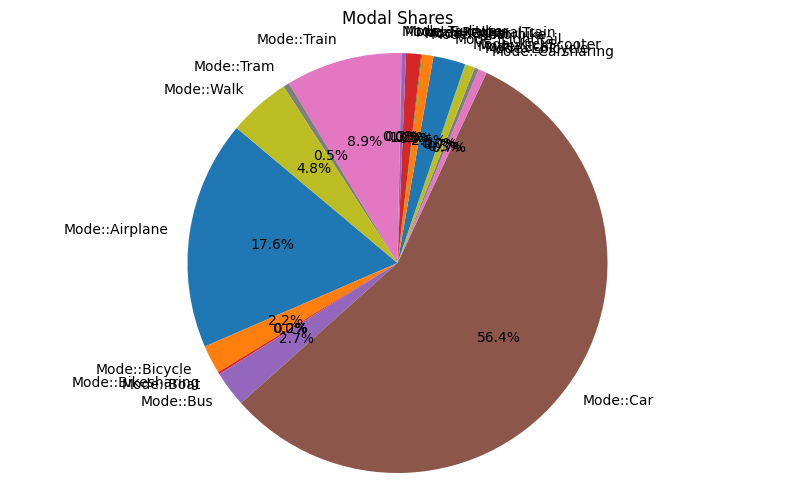

In [160]:
import matplotlib.pyplot as plt

# Plotting a Pie Chart
plt.figure(figsize=(10, 6))
mode_means = sum_mode_per_user_w.sum() / sum_mode_per_user_w.sum().sum()
plt.pie(mode_means, labels=mode_means.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Modal Shares')
plt.show()

In [193]:
legs.started_at.min()

Timestamp('2023-04-24 14:42:45')

In [194]:
legs.started_at.max()

Timestamp('2023-06-05 23:58:44')